In [173]:
import os
import sys
sys.path.insert(0, '../src/1_Spatial_Field_Generators/')

import importlib as oe

import Generators as gen
from Generators import RandomGenerator
from Plotting import ImagePlotter

import matplotlib.pylab as plt
import gc
import numpy as np
gc.collect()
from scipy.optimize import minimize

oe.reload(gen)

# Usage Example
# Generate texture
base_name = "fractal_noise"
generator = gen.PoresPyGenerator(size=(128, 128),name=base_name)
field_data = 2*(generator.generate(frequency=0.3,octaves=6) -0.5) # to scale from [-1,1]


Using seed: 4139457862
Porosity: 0.5005115866661072
Done! - Used the fractal_noise function with the following parameters: "shape": (128, 128)
metadata: {'generator_type': 'PoresPyGenerator/fractal_noise_/128_128', 'size': (128, 128), 'seed': 4139457862, 'porosity': 0.5005115866661072, 'octaves': 6, 'mode': 'simplex', 'gain': 0.5, 'frequency': 0.3}


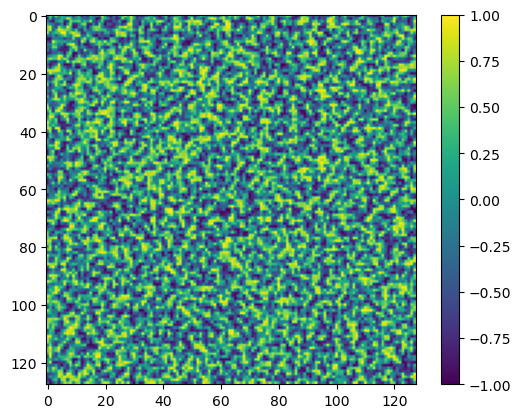

In [174]:
plt.imshow(field_data)
plt.colorbar()

In [175]:
#% Molar masses (Ca and Ti)
 #% Soil bulk density (g/cm3)
 #% Feedstock (basalt) density (g/cm3)
params_fixed = {'M_Ti' : 47.867, "M_Ca" : 40.078} 

#  % (made up, but reflective of data for Ca and Ti)
soil_params = {'soil_ppm_Ti' : 10000, "soil_ppm_Ca" : 20000, 'rho_soil' : 1.3,
               'field_data_Ca':field_data, 'field_data_Ti':field_data, 
               'num_indices_x' : field_data.shape[0], 'num_indices_y' : field_data.shape[1]}

feed_params = {'feed_ppm_Ti' : 17000, "feed_ppm_Ca" : 80000, 'Xf_init' : 0.01, 'rho_feed' : 2.7} # Xf is the fixed feedstock volume fraction
weathered_params = {'rho_weathered' : 1.3}

soil_params['soil_ppm_Ca_molg'] = soil_params['soil_ppm_Ca'] / (params_fixed['M_Ca'] * 1000) # this should be 1e-6 not 1e-3 ?
soil_params['soil_ppm_Ti_molg'] = soil_params['soil_ppm_Ti'] / (params_fixed['M_Ti'] * 1000) # this should be 1e-6 not 1e-3 ?
feed_params['feed_ppm_Ca_molg'] = feed_params['feed_ppm_Ca'] / (params_fixed['M_Ca'] * 1000) # this should be 1e-6 not 1e-3 ?
feed_params['feed_ppm_Ti_molg'] = feed_params['feed_ppm_Ti'] / (params_fixed['M_Ti'] * 1000) # this should be 1e-6 not 1e-3 ?
weathered_params['soil_ppm_Ca_molg'] = soil_params['soil_ppm_Ca'] / (params_fixed['M_Ca'] * 1000) # this should be 1e-6 not 1e-3 ?
weathered_params['soil_ppm_Ti_molg'] = soil_params['soil_ppm_Ti'] / (params_fixed['M_Ti'] * 1000) # this should be 1e-6 not 1e-3 ?

def make_soil_samples(var_Ca, var_Ti, tau_target, num_samples, soil_params, feed_params, weathered_params):
    #% tau = Xwf / (Xwf + Xf)    
    #% Xwf = tau * Xf / (1 - tau)
    print(f'Model with a feedstock volume fractions of {feed_params["Xf_init"]}')
    # Volume fraction of weathered material , We have specified the total feedstock volume fraction (Xf + Xwf) 
    Xwf_target = tau_target * feed_params['Xf_init'] 
    Xf = Xwf_target*(1 - tau_target)/tau_target; ## Volume fraction of feedstock 
    Xs = 1.0 -  feed_params['Xf_init']           ## Volume fraction of soil
    print(f'Model with params Xwf - {Xwf_target}, Xf - {Xf}')

    ## For every draw we have a soil reference for the mixing sample
    random_vals_Ca = np.random.choice(soil_params['field_data_Ca'].flatten(), size=num_samples, replace=True)
    random_vals_Ti = np.random.choice(soil_params['field_data_Ti'].flatten(), size=num_samples, replace=True)
    soil_j = (random_vals_Ca*var_Ca + 1)*soil_params['soil_ppm_Ca_molg']
    soil_i = (random_vals_Ti*var_Ti + 1)*soil_params['soil_ppm_Ti_molg']
    ij_min_denom = Xs*soil_params['rho_soil'] + Xf*feed_params['rho_feed'] + Xwf_target*weathered_params['rho_weathered']

    j_mix_num = Xs*soil_params['rho_soil']*soil_j + \
                Xf*feed_params['rho_feed']*feed_params['feed_ppm_Ca_molg'] + \
                Xwf_target*weathered_params['rho_weathered']*weathered_params['soil_ppm_Ca_molg'] ## Because the feedstock weathered isn't random
    i_wf = soil_i + (feed_params['rho_feed']/weathered_params['rho_weathered']) * (feed_params['feed_ppm_Ti_molg'] - weathered_params['soil_ppm_Ti_molg'])
    i_mix_num = Xs*soil_params['rho_soil']*soil_i + \
                Xf*feed_params['rho_feed']*feed_params['feed_ppm_Ti_molg'] + \
                Xwf_target*weathered_params['rho_weathered']*i_wf
    j_mix = j_mix_num / ij_min_denom
    i_mix = i_mix_num / ij_min_denom

    # Now setting up the soil reference for the inversion
    random_vals_Ca = np.random.choice(soil_params['field_data_Ca'].flatten(), size=num_samples, replace=True)
    random_vals_Ti = np.random.choice(soil_params['field_data_Ti'].flatten(), size=num_samples, replace=True)
    soil_j = (random_vals_Ca*var_Ca + 1)*soil_params['soil_ppm_Ca_molg']
    soil_i = (random_vals_Ti*var_Ti + 1)*soil_params['soil_ppm_Ti_molg']

    return soil_j,soil_i, j_mix, i_mix


def obj(inpt,params):
    Xwf,tau = inpt
    Xf = Xwf*(1 - tau)/tau
    i_obs, j_obs, soil_i, soil_j, soil_params, feed_params, weathered_params = params 
    Xs = 1.0 -  Xf - Xwf
    ij_min_denom = Xs*soil_params['rho_soil'] + Xf*feed_params['rho_feed'] + Xwf*weathered_params['rho_weathered']
    j_mix_num = Xs*soil_params['rho_soil']*soil_j + \
                Xf*feed_params['rho_feed']*feed_params['feed_ppm_Ca_molg'] + \
                Xwf*weathered_params['rho_weathered']*weathered_params['soil_ppm_Ca_molg'] ## Because the feedstock weathered isn't random
    i_wf = soil_i + (feed_params['rho_feed']/weathered_params['rho_weathered']) * (feed_params['feed_ppm_Ti_molg'] - soil_params['soil_ppm_Ti_molg'])
    i_mix_num = Xs*soil_params['rho_soil']*soil_i + \
                Xf*feed_params['rho_feed']*feed_params['feed_ppm_Ti_molg'] + \
                Xwf*weathered_params['rho_weathered']*i_wf
    j_mix = j_mix_num / ij_min_denom
    i_mix = i_mix_num / ij_min_denom
    err = (i_mix - i_obs)**2 + (j_mix - j_obs)**2
    return np.log10(err)

def estimate_tau_Xwf(params):
    res = minimize(obj, x0=[0.005, 0.1], args=(params), method='Nelder-Mead', bounds=[(0.0001, 0.2), (0.01, 0.9)],tol=1e-6,options={'maxiter':1e5})
    return res.x

def estimate_tau_Xwf_BruteForce(Tau_test_all,X_wf_test_all,params):
    res = obj((X_wf_test_all,Tau_test_all),params)
    min_indx = np.argmin(res)    
    return Tau_test_all[min_indx],X_wf_test_all[min_indx],np.min(res)


In [176]:
#% --- Target Parameters ---
tau_target = 0.3;       #% tau = Xwf / (Xwf + Xf)             
var_Ca = 0.01;         #% Standard error threshold on Ca - 1% (1+var*field)*Ca
var_Ti = 0.01;         #% Standard error threshold on Ti - 1%
num_samples = 500         # Max number of samples

soil_j,soil_i, j_mix, i_mix = make_soil_samples(var_Ca, var_Ti, tau_target, num_samples, soil_params, feed_params, weathered_params)

tau_estimate = np.zeros(num_samples)
Xwf = np.zeros(num_samples)
res_fit = np.zeros(num_samples)

###################################################
Tau_vals_test = np.linspace(0.01,0.9,200)
Xwf_vals_test = np.linspace(0.001,0.01,100)
Tau_test_all,X_wf_test_all = np.meshgrid(Tau_vals_test,Xwf_vals_test)
Tau_test_all = Tau_test_all.flatten()
X_wf_test_all = X_wf_test_all.flatten()
###################################################

for i in range(num_samples):
    params = [i_mix[i], j_mix[i], soil_i[i], soil_j[i], soil_params, feed_params, weathered_params]
    tau_estimate[i],Xwf[i],res_fit[i] = estimate_tau_Xwf_BruteForce(Tau_test_all,X_wf_test_all,params)
        
Xf = Xwf*(1 - tau_estimate)/tau_estimate

Model with a feedstock volume fractions of 0.01
Model with params Xwf - 0.003, Xf - 0.007


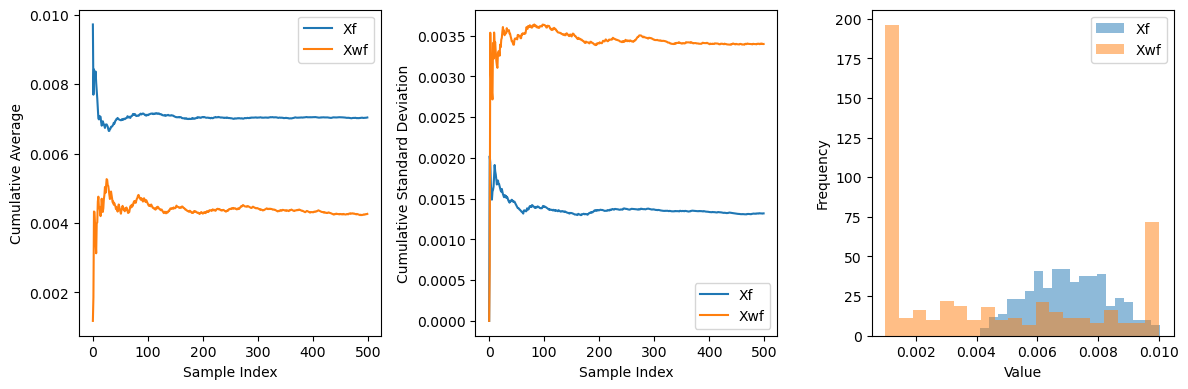

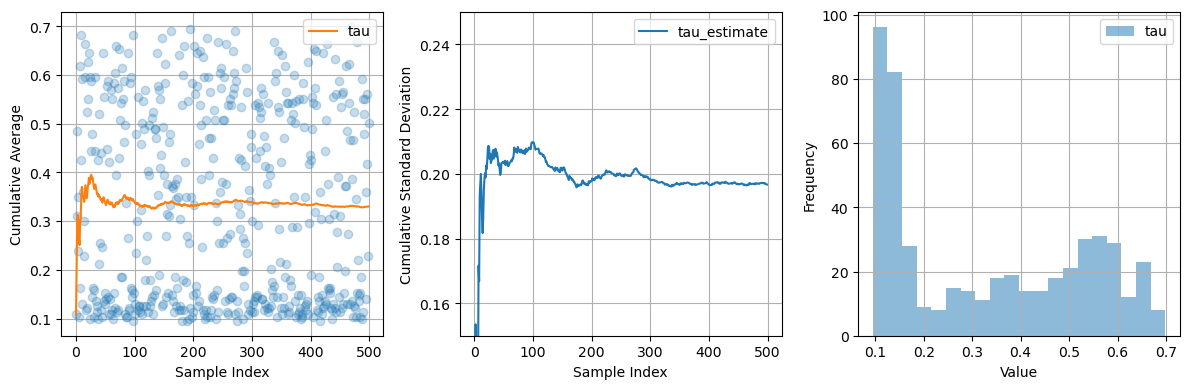

In [195]:
# assuming Xf and Xwf are numpy arrays
cum_avg_Xf = np.cumsum(Xf) / np.arange(1, len(Xf) + 1)
cum_avg_Xwf = np.cumsum(Xwf) / np.arange(1, len(Xwf) + 1)

cum_std_Xf = np.array([np.std(Xf[:i+1]) for i in range(len(Xf))])
cum_std_Xwf = np.array([np.std(Xwf[:i+1]) for i in range(len(Xwf))])

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(cum_avg_Xf, label='Xf')
plt.plot(cum_avg_Xwf, label='Xwf')
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Average')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(cum_std_Xf, label='Xf')
plt.plot(cum_std_Xwf, label='Xwf')
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Standard Deviation')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(Xf, bins=20, alpha=0.5, label='Xf')
plt.hist(Xwf,bins=20,  alpha=0.5, label='Xwf')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

cum_avg_tau = np.cumsum(tau_estimate) / np.arange(1, len(tau_estimate) + 1)
cum_std_tau = np.array([np.std(tau_estimate[:i+1]) for i in range(len(tau_estimate))])

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(tau_estimate, 'o',alpha=0.25)
plt.plot(cum_avg_tau, label='tau')
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Average')
plt.legend()
plt.grid('on')

plt.subplot(1, 3, 2)
plt.plot(cum_std_tau, label='tau_estimate')
plt.ylim([0.15,0.25])
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Standard Deviation')
plt.legend()
plt.grid('on')

plt.subplot(1, 3, 3)
plt.hist(tau_estimate, bins=20, alpha=0.5, label='tau')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid('on')
plt.tight_layout()
plt.show()




In [191]:
dollar_per_sample = 50.0
price_ton = 300.0
Integrated_application_Tons_basalt = 10000.0

cost = dollar_per_sample*np.arange(1, len(Xf) + 1)
income = (cum_avg_tau-cum_std_tau)*price_ton*feed_params['Xf_init']*Integrated_application_Tons_basalt



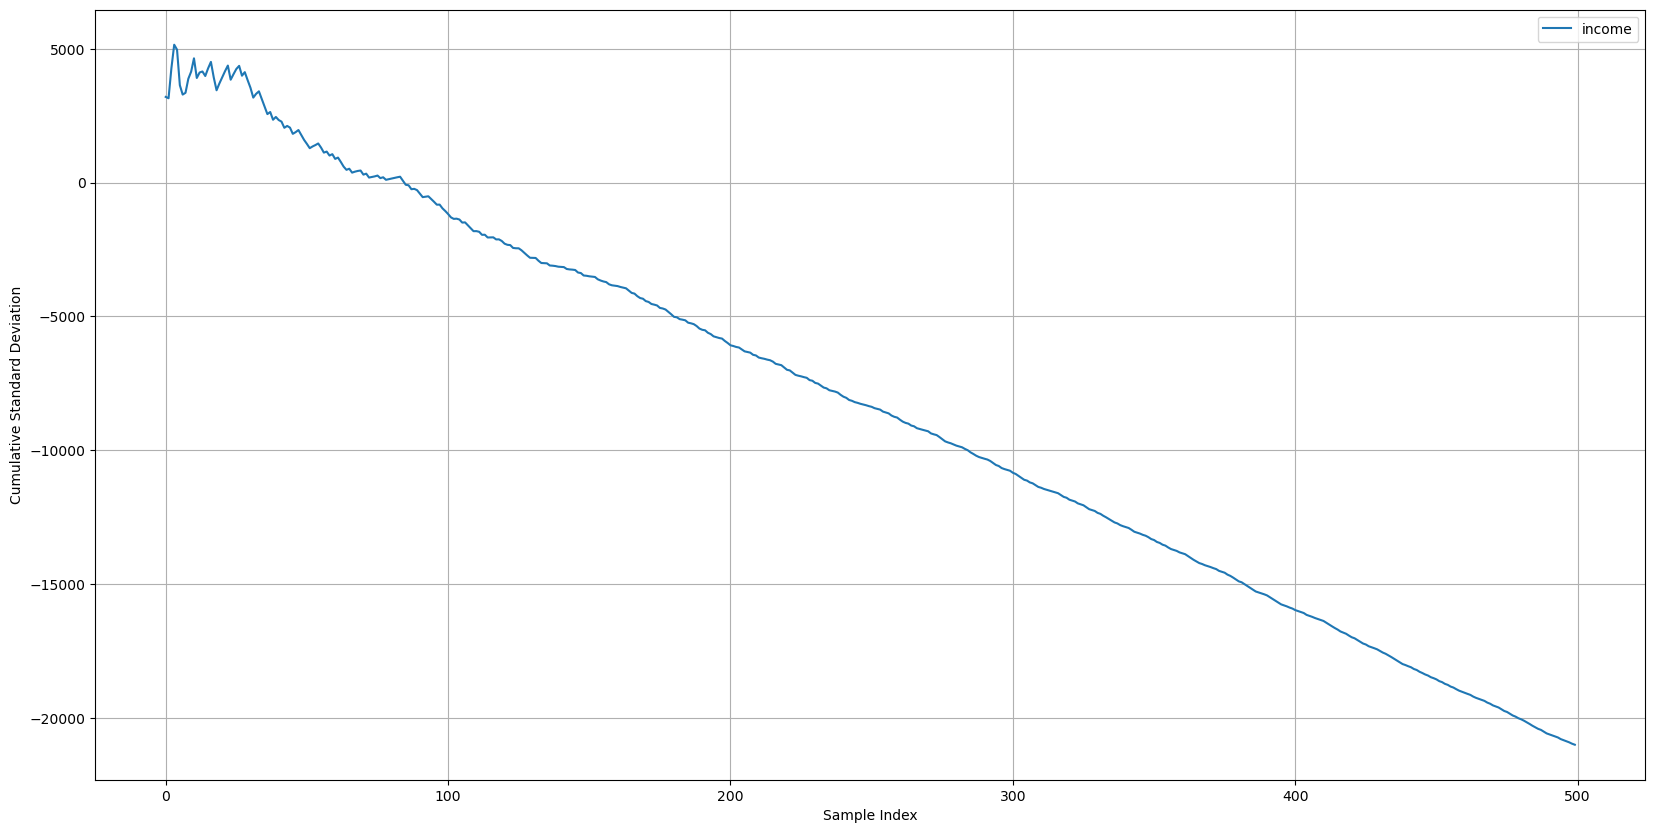

In [193]:
plt.figure(figsize=(20,10))
plt.plot(income-cost, label='income')
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Standard Deviation')
plt.legend()
plt.grid('on')
